<a href="https://colab.research.google.com/github/sumitra288/ML-LAB-A1-G3-/blob/main/experiment%207.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv('./mall_customers.csv')

df.head()

df = df.select_dtypes(include=[np.number])

df = df.dropna(how="all").dropna(axis=1, how="all")

if df.empty:
    raise ValueError("No numeric data found in dataset!")

X = df.values


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

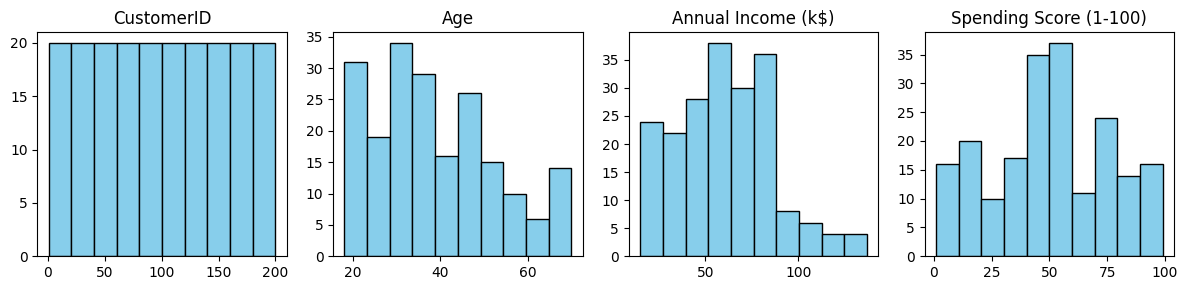

In [ ]:
features = df.columns
plt.figure(figsize=(12, 3))

for i, f in enumerate(features):
    col = X[:, i]
    valid_col = col[~np.isnan(col)]
    if len(valid_col) == 0:
        print(f"Skipping {f} — all NaN values")
        continue
    plt.subplot(1, len(features), i + 1)
    plt.hist(valid_col, bins=10, color='skyblue', edgecolor='black')
    plt.title(f)

plt.tight_layout()
plt.show()

In [ ]:
def initialize_centroids(X, k, init='random', random_state=None):
    np.random.seed(random_state)
    n_samples = X.shape[0]

    if init == 'random':
        indices = np.random.choice(n_samples, k, replace=False)
        return X[indices]

    elif init == 'kmeans++':
        centroids = [X[np.random.randint(0, n_samples)]]
        for _ in range(1, k):
            dist_sq = np.min(np.square(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)), axis=1)
            probs = dist_sq / np.sum(dist_sq)
            next_centroid = X[np.random.choice(n_samples, p=probs)]
            centroids.append(next_centroid)
        return np.array(centroids)

    else:
        raise ValueError("init must be 'random' or 'kmeans++'")

def kmeans(X, k, max_iters=300, tol=1e-4, init='kmeans++', random_state=None):
    centroids = initialize_centroids(X, k, init, random_state)

    for i in range(max_iters):
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        for j in range(k):
            if np.isnan(new_centroids[j]).any():
                new_centroids[j] = X[np.random.choice(X.shape[0])]

        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    inertia = np.sum((X - centroids[labels]) ** 2)
    return centroids, labels, i + 1, inertia

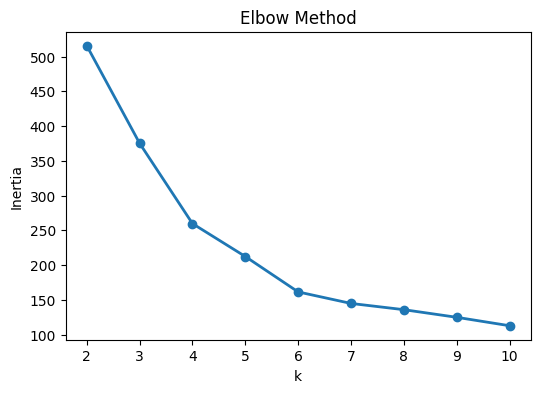

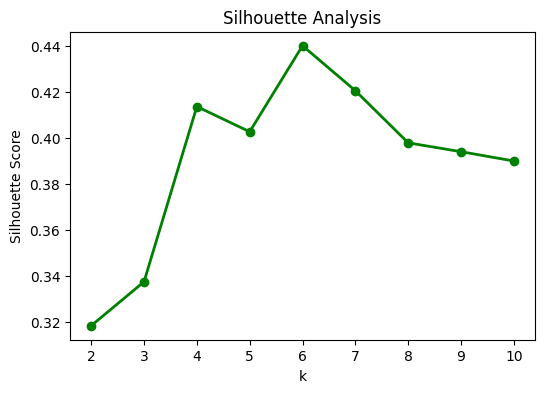

Best k (based on Silhouette Score): 6


In [ ]:
inertias, sil_scores = [], []
K = range(2, 11)

for k in K:
    centroids, labels, iters, inertia = kmeans(X_scaled, k, init='kmeans++', random_state=42)
    inertias.append(inertia)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6, 4))
plt.plot(K, inertias, 'o-', linewidth=2)
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(K, sil_scores, 'o-', color='green', linewidth=2)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

best_k = K[np.argmax(sil_scores)]
print(f"Best k (based on Silhouette Score): {best_k}")

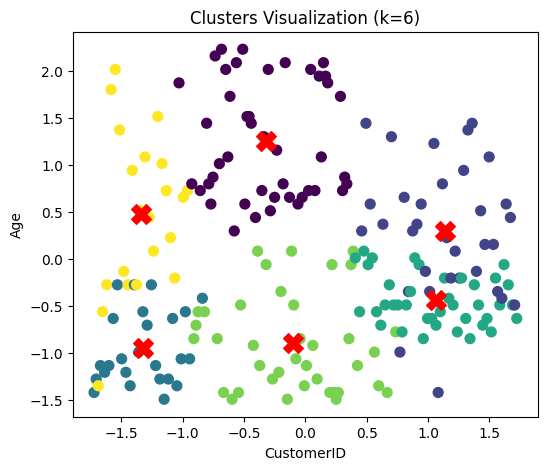

In [ ]:
centroids, labels, _, _ = kmeans(X_scaled, best_k, init='kmeans++', random_state=42)

if X_scaled.shape[1] >= 2:
    plt.figure(figsize=(6, 5))
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=50)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X')
    plt.title(f'Clusters Visualization (k={best_k})')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.show()